# Entreno en 5000 pruebo en TODO

In [9]:
import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

import joblib

from sklearn.ensemble import forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc

forest.DTYPE = np.float64

## Funcion de ayuda

In [10]:
def run_test(clf, tile, X_columns, y_column):
    X_test = tile[X_columns].values.astype(np.float32)
    y_test = tile[y_column].values.astype(np.float32)
    
    print np.all(np.isfinite(X_test))
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    print metrics.classification_report(y_test, predictions)
    
    return Container({
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'y_test': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})

In [11]:
sample = pd.read_pickle("data/o3o4vZ/scaled/s5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
train = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

Reescalamos la muestra de TOTAL con media y desvio del de 5k

In [12]:
skl = pickle.load(open("data/o3o4vZ/scalers/scaler_5k.pkl"))

In [13]:
def to_float32(df):
    df = df.copy()
    df[X_columns] = df[X_columns].apply(pd.to_numeric, downcast='float')
    df = df[~df.Period_fit.isin([-np.inf, np.inf])]
    return df

sample = pd.read_pickle("data/o3o4vZ/nonull/sALL.pkl.bz2")

sample[X_columns] = skl.transform(sample[X_columns])
sample = to_float32(sample)

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample
test

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


<Container({'b261': 571754, 'b278': 774631})>

In [14]:
cpu = joblib.cpu_count()
clf_med = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu)
clf_med.fit(train.b278[X_columns].values, train.b278.cls.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=48,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
result_med = run_test(clf_med, test.b261, X_columns, "cls")

True
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    571501
         1.0       0.19      0.83      0.32       253

   micro avg       1.00      1.00      1.00    571754
   macro avg       0.60      0.92      0.66    571754
weighted avg       1.00      1.00      1.00    571754



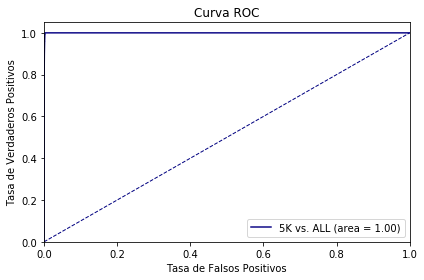

In [8]:
roc({"5K vs. ALL": result_med})